# A-1 Data Processing and EDA
#### 1. There should be 3 dataset splits for this homework, data train, data valid and data test. The data test doesn’t have ground truth labels, you need to use the trained model to do inference on it. Read the data.

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_train = pd.read_csv('data_train-1.csv', index_col=0)
data_test = pd.read_csv('data_test-1.csv', index_col=0)
spl = int(len(data_train)*.8)
data_valid = data_train[spl:]
data_train = data_train[:spl]
# print(f'TRAINING:\n{data_train}\n\nVALIDATION:\n{data_valid},\n\nTESTING:\n{data_test}')
print('Train')
print(data_train.describe())
print(data_train.head())
print('Valid')
print(data_valid.describe())
print(data_valid.head())
print('Test')
print(data_test.describe())
print(data_test.head())

Train
       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       392.000000         392.000000  378.000000        384.000000   
mean       5343.081633        1592.862245  145.253968        342.875000   
std        5301.608059        2984.971645   81.768380         63.586663   
min         150.000000           0.000000    9.000000         12.000000   
25%        2921.750000           0.000000  100.000000        360.000000   
50%        3871.000000        1062.000000  128.500000        360.000000   
75%        5823.000000        2312.000000  165.000000        360.000000   
max       63337.000000       41667.000000  650.000000        480.000000   

       Credit_History  
count      356.000000  
mean         0.859551  
std          0.347942  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  
    Loan_ID Gender Married Dependents Education Self_Employed  \
0  LP001518   Male     Yes          1

#### 2. Print the training data. How does the data look like? Add a short description about the data.

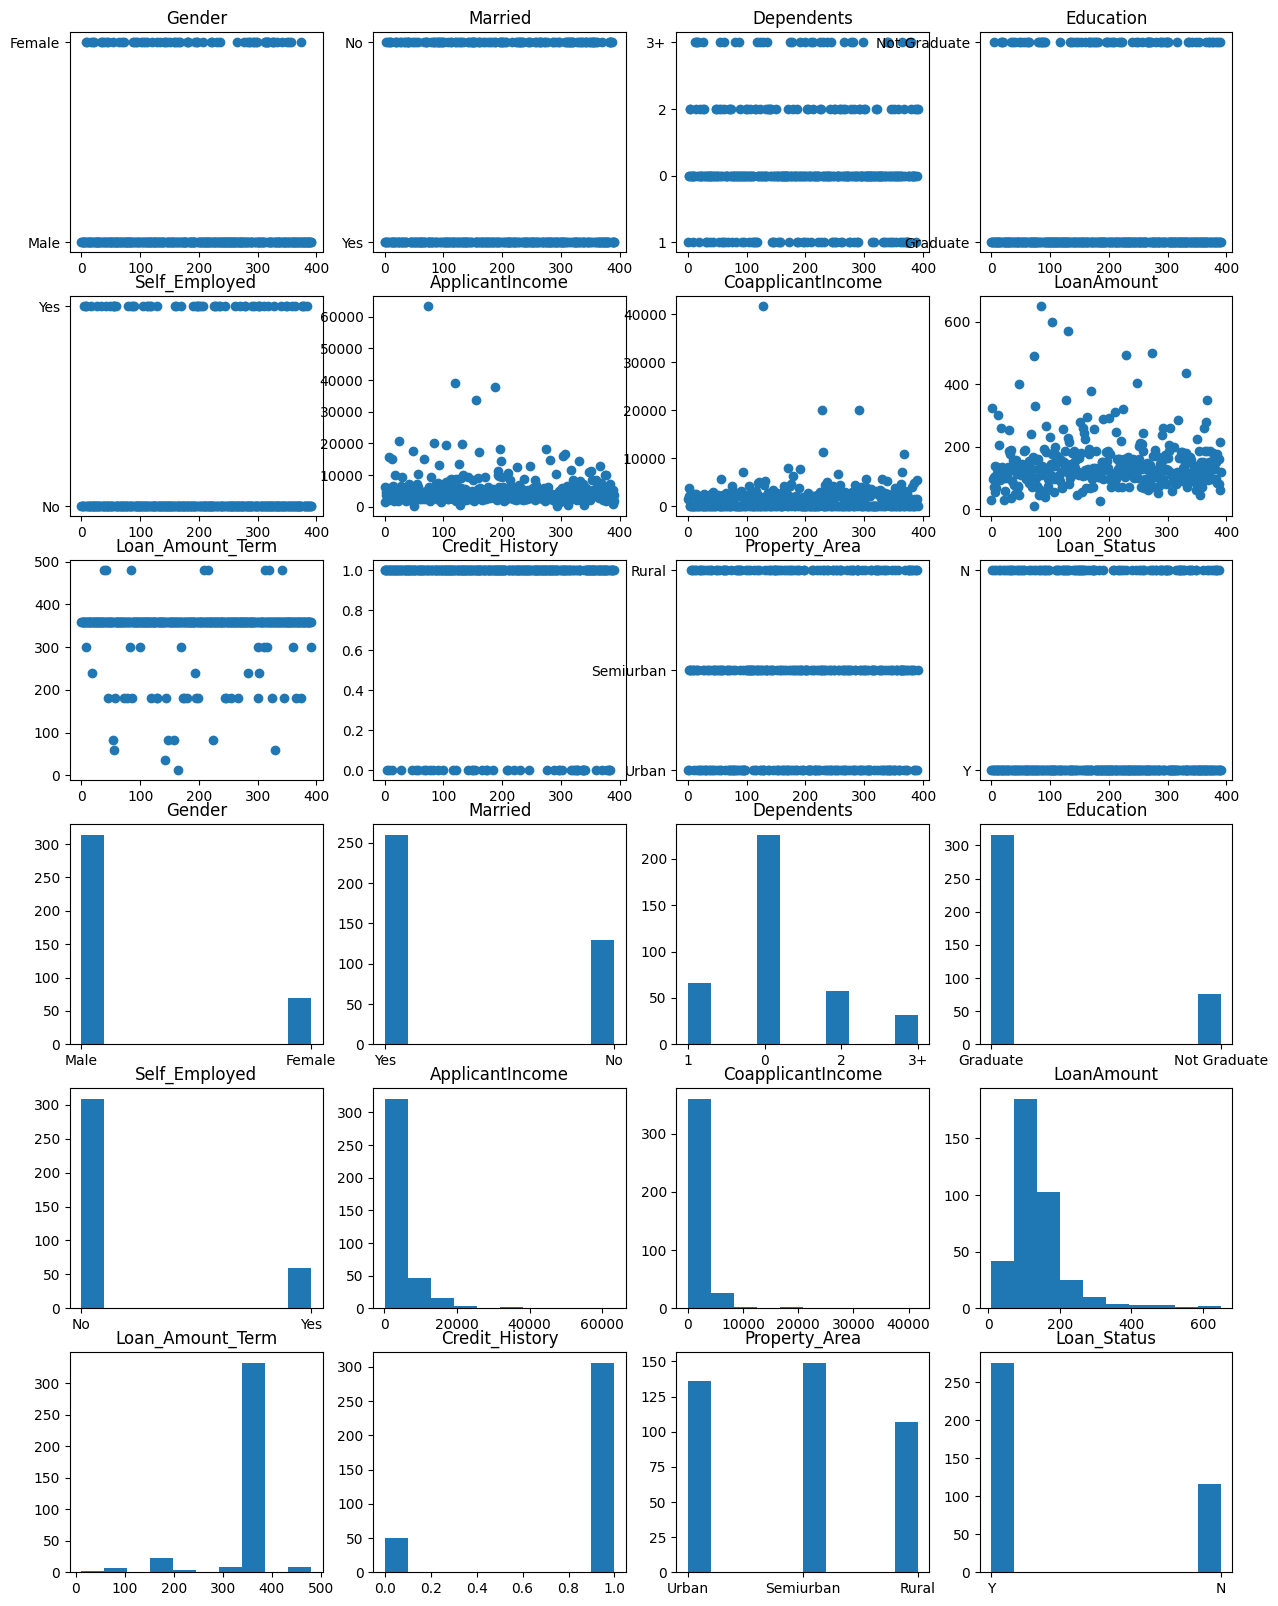

In [156]:
# c = int(len(data_train)/3)
fig , ax = plt.subplots(6,4,figsize=(15,20))
ax = np.ravel(ax) # you can iteratively fill a 1D vector and later reshape it back to a 2D grid when plotting Aknowledgement: https://stackoverflow.com/questions/50180981/reshape-axes-in-figure-using-matplotlib
# the first column is unique labes, dropping is lets us plot 12 labels as 3x4 (or 24 as 6x4)
for i, col in enumerate(data_train.columns[1:]):
    y = data_train[col].dropna()
    ax[i].scatter(y.index,y)
    ax[i+12].hist(y)
    ax[i].set_title(col)
    ax[i+12].set_title(col)
ax = np.reshape(ax, (6,4))
plt.show()

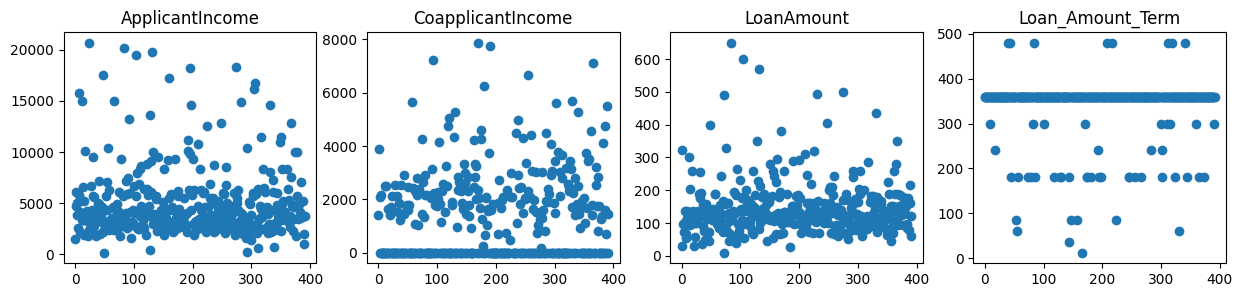

In [157]:
f,a = plt.subplots(1,4,figsize=(15,3))
for i, col in enumerate(data_train.columns[6:10]):
    if i>1:
        y = data_train[col].dropna()
        a[i].scatter(y.index,y)
    a[i].set_title(col)
y = data_train['ApplicantIncome'].loc[data_train['ApplicantIncome']<30000]
a[0].scatter(y.index,y)
y = data_train['CoapplicantIncome'].loc[data_train['CoapplicantIncome']<10500]
a[1].scatter(y.index,y)
plt.show()

I printed head in part 1, so I plotted the data using scatter and hist.
Much of the data is categorical. I want to keep an eye on most of these features, they either split the data in interesting chunks and seem likely have good insights on our target. Our data contains mostly educated, married men so any data for uneducated, unmarried, or women my be goof indicators.
Out of the numeric data (I rescaled the first 2 for a better look), I know right away I want to check ApplicantIncome+CoapplicantIncome at thresholds ~3870, 5000, 7000. Loan_Amount_Term could be considered categorical.<br>
> ApplicantIncome trends towards ~3870<br>
> CoapplicantIncome is very often 0<br>
> LoanAmounts and Terms trend towards 130 and 360 respectively

I believe credit history will be high up on most trees

#### 3. Return the shape of the data.

In [158]:
print(f'Shape={data_train.shape}\t\t{data_train.shape[0]} Datapoints\t{data_train.shape[1]} Columns (Unique IDs[{0}], Target[{data_train.shape[1]-1}])')

Shape=(392, 13)		392 Datapoints	13 Columns (Unique IDs[0], Target[12])


#### 4. Does the data have any missing values? How many are missing? Return the number of missing values.

In [159]:
print('Column\t    Null Values')
nan = data_train.isna().sum()
print(nan)
print(nan.sum())

Column	    Null Values
Loan_ID               0
Gender                9
Married               3
Dependents           10
Education             0
Self_Employed        24
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           14
Loan_Amount_Term      8
Credit_History       36
Property_Area         0
Loan_Status           0
dtype: int64
104


Loan Amount, Term, Credit History nulls almost certainly mean Target=No, likely Self Employed null as well. I would double check that first, then group them all into 1 decision to catch between 36-104 datapoints. I'd let it vote

In [160]:
print('Any nan')
print(data_train[data_train.isna().any(axis=1)]['Loan_Status'])
boxes = ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']
print(f'\nnan in {boxes}')
print(data_train.loc[data_train[boxes].isna().any(axis=1),['Loan_Status']])

Any nan
2      N
4      N
11     Y
18     Y
23     Y
      ..
382    N
386    Y
388    Y
389    Y
390    Y
Name: Loan_Status, Length: 93, dtype: object

nan in ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']
    Loan_Status
2             N
18            Y
23            Y
24            N
27            N
31            N
33            N
53            Y
58            Y
69            Y
75            Y
77            N
80            Y
84            Y
86            N
91            N
94            N
121           N
127           Y
128           N
148           Y
165           Y
181           Y
187           Y
193           Y
206           Y
207           Y
209           N
214           Y
215           Y
222           Y
234           Y
235           Y
236           Y
249           Y
251           N
252           Y
264           Y
289           Y
294           Y
296           N
297           N
298           N
308           Y
309           Y
310           Y
313           Y
318           Y
323

I think this bank should be investigated.

#### 5. Drop all the rows with any missing data.

In [161]:
data_train.dropna(inplace=True)
data_valid.dropna(inplace=True)
data_test.dropna(inplace=True)
data_train.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

#### 6. Extract the features and the label from the data. Our label is Loan Status in this case

In [162]:
X = data_train.loc[:, data_train.columns!='Loan_Status'].copy(deep=True)
# we dont want to assume anything from the label column
X.drop('Loan_ID', axis=1, inplace=True)
Xv = data_valid.loc[:, data_train.columns!='Loan_Status'].copy(deep=True)
Xv.drop('Loan_ID', axis=1, inplace=True)
y = data_train[['Loan_Status']]
yv = data_valid[['Loan_Status']]

Xt = data_test.copy(deep=True)
Xt.drop('Loan_ID', axis=1, inplace=True)

# Add Features: (TotalIncome is popular)
X['TotalIncome'] = X['ApplicantIncome'] + X['CoapplicantIncome']
Xv['TotalIncome'] = Xv['ApplicantIncome'] + Xv['CoapplicantIncome']
Xt['TotalIncome'] = Xt['ApplicantIncome'] + Xt['CoapplicantIncome']

# Normalize numeric columns:
# I want this feature to be numeric since amount and order matters. To achieve this I will generalize 3+=4 for a guess average
X['Dependents'] = X['Dependents'].map(lambda x:4 if x=='3+' else int(x))
Xv['Dependents'] = Xv['Dependents'].map(lambda x:4 if x=='3+' else int(x))
Xt['Dependents'] = Xt['Dependents'].map(lambda x:4 if x=='3+' else int(x))
# X['ApplicantIncome'] = (X['ApplicantIncome'] - X['ApplicantIncome'].mean())/X['ApplicantIncome'].std()
# X['CoapplicantIncome'] = (X['CoapplicantIncome'] - X['CoapplicantIncome'].mean())/X['CoapplicantIncome'].std()
# X['TotalIncome'] = (X['TotalIncome'] - X['TotalIncome'].mean())/X['TotalIncome'].std()

print(f'X:\n{X}\n\ny:\n{y}')

X:
    Gender Married  Dependents     Education Self_Employed  ApplicantIncome  \
0     Male     Yes           1      Graduate            No             1538   
1     Male     Yes           0      Graduate            No             6133   
3     Male     Yes           2      Graduate            No             3859   
5     Male      No           0  Not Graduate           Yes             2583   
6     Male     Yes           0      Graduate            No             5829   
..     ...     ...         ...           ...           ...              ...   
383   Male      No           0      Graduate            No             4166   
384   Male      No           0      Graduate           Yes             7085   
385   Male      No           0      Graduate            No             3750   
387   Male      No           0      Graduate            No             3600   
391   Male     Yes           2      Graduate            No             3717   

     CoapplicantIncome  LoanAmount  Loan_Amount_

#### 7. Plot the histograms of all the variables in the data

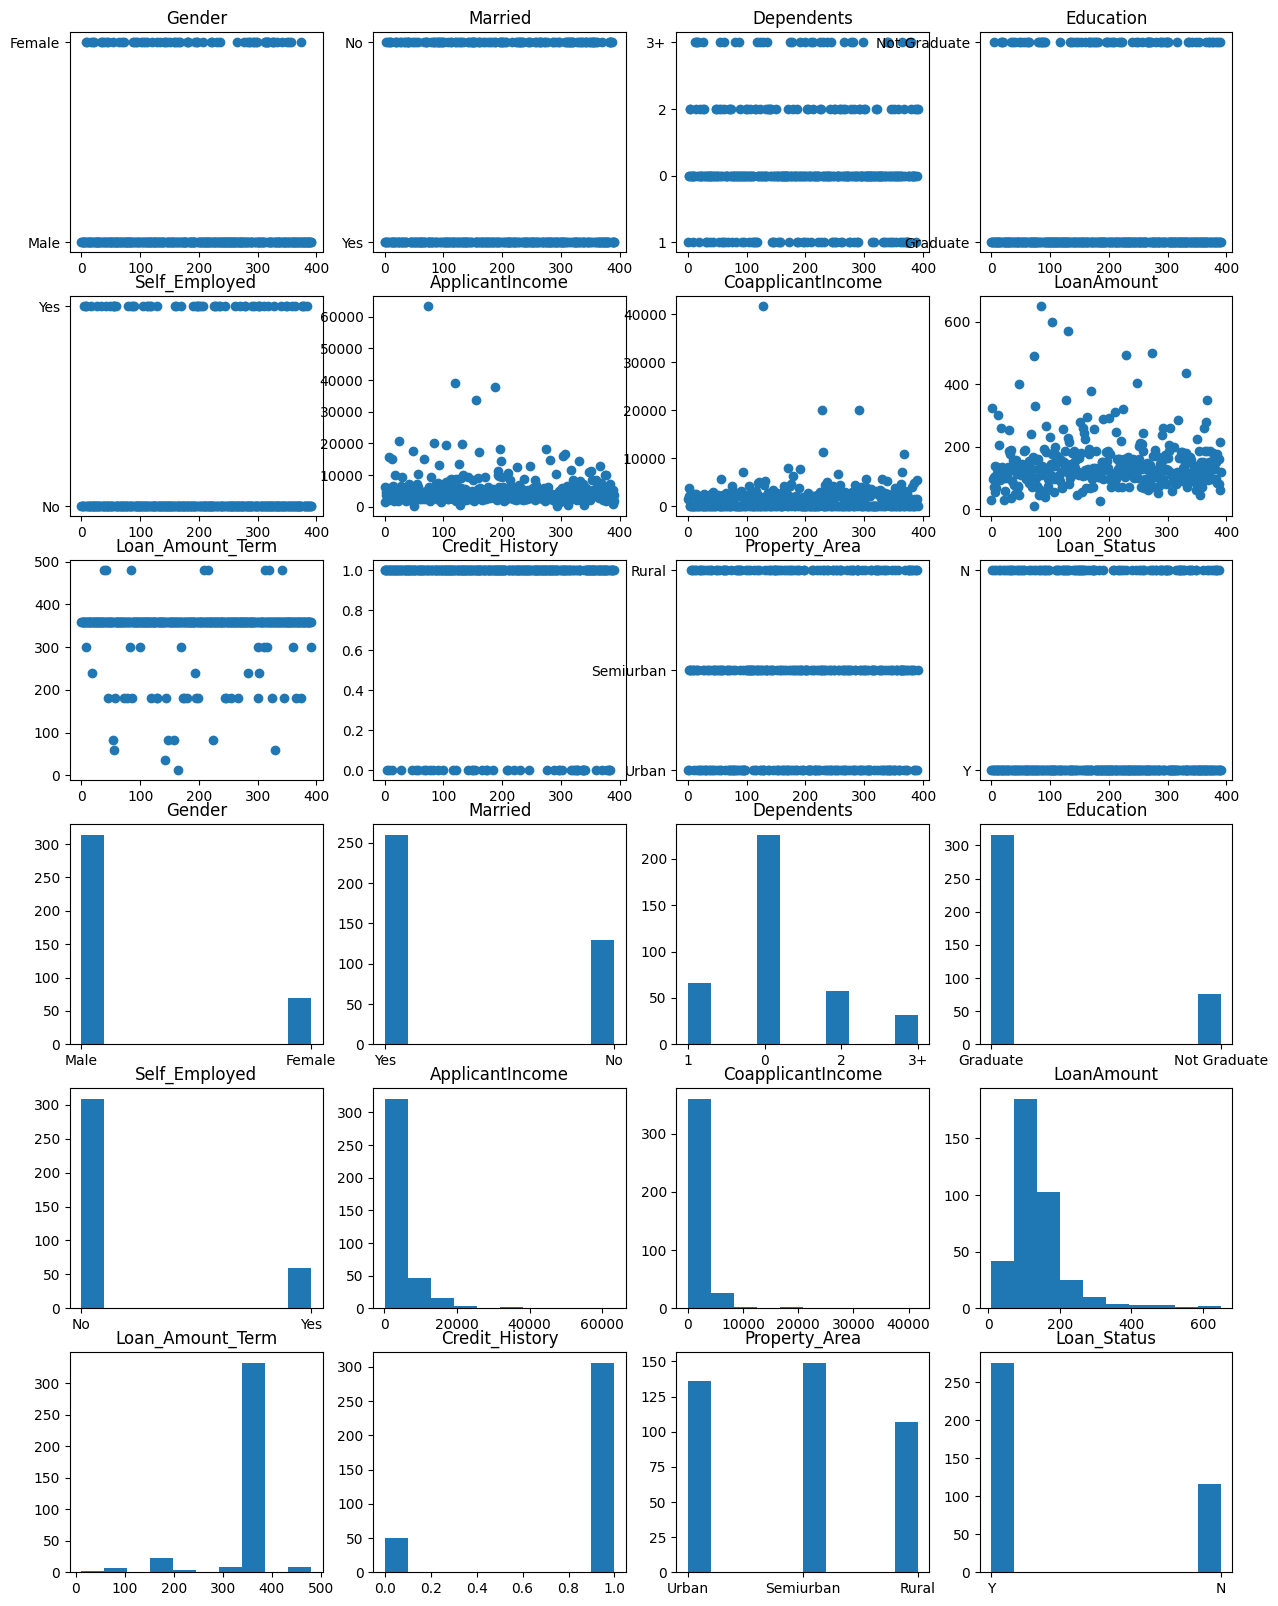

In [163]:
fig

As I said in 2. our data represents mostly educated and married men. Slightly more data for no kids than 1+ kids.
> Diverse Property_Area.
> Most applicants have a Credit_History, but we don't gain information past that.
> No Credit_History may be important, although not very populated.
> Self_Employed is the same

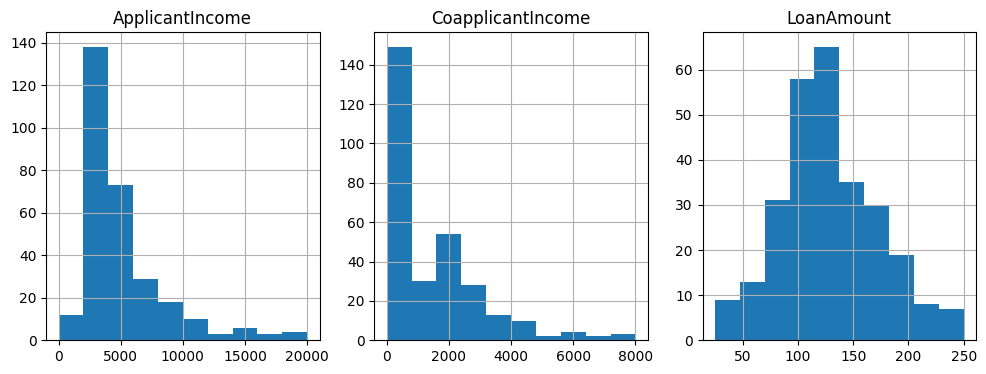

In [164]:
f,a = plt.subplots(1,3,figsize=(12,4))
X['ApplicantIncome'].hist(range=(0,20000), ax=a[0])
X['CoapplicantIncome'].hist(range=(0,8000), ax=a[1])
X['LoanAmount'].hist(range=(25,250), ax=a[2])
a[0].set_title('ApplicantIncome')
a[1].set_title('CoapplicantIncome')
a[2].set_title('LoanAmount')
plt.show()

360 is the manin category of Loan_Amount_Term. Not 360 may be an interesting split.<br>
On rescaled histograms of numeric data we see that most ApplicantsIncome is less than 5000, most CoapplicantIncome near 0, and LoanAmount is normally distributed μ=128

# A-2 Implementation
#### 1. Implement a classification tree from scratch for prediction.

In [165]:
from collections import Counter

import numpy as np
### Week 5 Discussion: Decision Tree  ###

def entropy(y):
    hist = pd.Series(y).value_counts() # now returns count of each label in y
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])


class Node:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, *, value=None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None
        self.names = None
        # self.used_feats = set()
        # self.used_feats = dict()
        self.w = None # currently this is flawed since it prevents reusing columns by depth, even if only one side of a tree used it

    def fit(self, X, y, names=None):
        self.names = names
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.w = np.ones([self.max_depth+1, self.n_feats]) # description above
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = self._most_common_label(y)
            print(depth,'\t',leaf_value)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs,depth)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs,depth):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            # if feat_idx in self.used_feats: continue # print(f'skip {names[feat_idx]}');
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                # if feat_idx in self.used_feats.keys() and len(thresholds)>15:
                #     if abs(self.used_feats[feat_idx]-threshold < X[:,feat_idx].std()/2):
                #         continue # skip reusing similar thresholds on numeric features
                gain = self._information_gain(y, X_column, threshold) * self.w[depth,feat_idx] # weight index to punish reusing columns
                if gain > best_gain:
                    # if type(self.names):print(f'Gain {self.names[feat_idx]}[{threshold}]:{gain}\t({self.w[depth,feat_idx]})') # weight & label printouts for debugging
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        if type(self.names): print(depth,'\t',self.names[split_idx],split_thresh)
        else: print(split_idx,split_thresh)
        # self.used_feats[split_idx] = split_thresh
        self.w[depth+1,split_idx] *= .25 # punish using it next harshly
        self.w[depth+1:,split_idx] *= .85 # punish using it again less
        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        if counter==Counter():
            print('/',end='')
            return 'N'
        most_common = counter.most_common(1)[0][0]
        return most_common

#### 2. Train the model using training data and use validation data to validate the trained model

In [166]:
def score(y_true, y_pred):
        TP,TN,FP,FN = 0,0,0,0
        printout = []
        for i,p in enumerate(y_pred):
            if y_true[i]==p:
                if p=='Y': TP += 1
                else: TN += 1
            else:
                if p=='Y': FP += 1; printout.append(i)
                else: FN += 1; printout.append(i)
        print(f'Missed: {printout}')
        return [(TP+TN)/(TP+TN+FP+FN),(TP)/(TP+FP),(TP)/(TP+FN),(TP)/(TP+0.5*(FP+FN))]

# subset = X.columns
subset = ['Dependents','Education','TotalIncome','Credit_History','Property_Area','LoanAmount','Married','Gender','Self_Employed']
X_train = np.array(X[subset])
y_train = np.array(y).reshape(y.size)
X_vali = np.array(Xv[subset])
y_vali = np.array(yv).reshape(yv.size)
S = dict()
for d in [3]: # 3 is typically the best depth from 0~15
    print('\n',d)
    clf = DecisionTree(max_depth=d)
    # X.set_index(np.linspace(0,len(X),num=len(X),endpoint=False,dtype=int),inplace=True,drop=True)
     # ['Dependents','Education','TotalIncome','Credit_History','Property_Area','LoanAmount']
    clf.fit(X_train,y_train,names=X[subset].columns)
    pred = clf.predict(X_vali)

    scores = score(y_vali,pred)
    S[d]=scores[0]
    print(f"Accuracy: {scores[0]}\nPrecision: {scores[1]}\nRecall: {scores[2]}\nF1: {scores[3]}")
print(S)


 3
0 	 Credit_History 0.0
1 	 TotalIncome 4787.0
2 	 N
2 	 LoanAmount 90.0
3 	 Y
3 	 N
1 	 TotalIncome 2378.0
2 	 Education Graduate
3 	 N
3 	 N
2 	 LoanAmount 148.0
3 	 Y
3 	 Y
Missed: [7, 10, 11, 15, 20, 28, 29, 31, 32, 39, 43, 44, 64, 71]
Accuracy: 0.8108108108108109
Precision: 0.7758620689655172
Recall: 0.9782608695652174
F1: 0.8653846153846154
{3: 0.8108108108108109}


I played around by shrinking the weight of a label for every depth after it was used. My label for TotalIncome became very dominant in the trees (as expected, it is a main deciding factor) so I wanted to restrict how often it was used.

Depth 2 scores = Depth 3 scores, but depth=3 uses better splits in my opinion, so I am moving forward with that.

<pre>
Credit_History
|___________________________
|0                          |1
TotalIncome                 TotalIncome
|_______                    |______________
|<=4787 |>4787              |<=2378        |>2378
N       TotalIncome         Edu            LoanAmount
        |_______            |_______       |_______
        |<=4949 |>4949      |Grad   |No    |<=148  |
        Y       N           N       N      Y       Y
</pre>

Which is essentially

<pre>
Credit_History
|___________________________
|0                          |1
TotalIncome                 TotalIncome
|_______                    |______________
|<=4787 |>4787              |<=2378        |>2378
N       TotalIncome         N              Y
        |_______            
        |<=4949 |>4949      
        Y       N           
</pre>

We gain 1 Y bucket from an extra depth

I find it odd 4787<TotalIncome<=4949:Y and 4949<TotalIncome:N<br>
I also am surprised to see the label reused considering I have already lowered the weight of of TotalIncome information gain by half.

I would think a different label would provide more information so finally I am going to try reducing the weight of using the same label twice in a row to about quarter, and the weight of using the same label again at all to 85%. I am also going to remove the two income labels that are used to compute TotalIncome so that they don't abuse the weight change

<pre>
Credit_History
|___________________________
|0                          |1
TotalIncome                 TotalIncome
|_______                    |______________
|<=4787 |>4787              |<=2378        |>2378
N       LoanAmount          PrprtyArea     LoanAmount
        |_______            |_______       |_______
        |<=90   |>90        |Rural  |Not   |<=148  |>148
        Y       N           N       N      Y       Y
</pre>

Which is essentially

<pre>
Credit_History
|___________________________
|0                          |1
TotalIncome                 TotalIncome
|_______                    |______________
|<=4787 |>4787              |<=2378        |>2378
N       LoanAmount          N              Y
        |_______            
        |<=90   |>90        
        Y       N           
</pre>

Same buckets as before with the same scores, but this time using different features that make sense working together. I also would like to note that adjusting weights this way seemed to increase the scores for deeper trees. depth=12 sometimes scored the same as depth=2,3. I read through the tree and liked what I saw, but I believe that it mislabels the first test sample due to overfitting.

I would like to try making a few trees and restricting the features each can use. I belive Credit_History should likely be in most trees since its the most important, but I would like to see the features that show up without it.

In [167]:
# ['Dependents','Education','TotalIncome','Credit_History','Property_Area','LoanAmount','Married','Gender','Self_Employed']
sets = []
sets.append(['Credit_History','TotalIncome','LoanAmount']) # the big 3
sets.append(['Credit_History','LoanAmount','Property_Area'])
sets.append(['Credit_History','Married','Dependents'])
sets.append(['Credit_History','Education','Dependents'])
sets.append(['Credit_History','Education','TotalIncome','LoanAmount'])
sets.append(['Credit_History','Education','LoanAmount'])
sets.append(['Credit_History','Education','Gender'])
sets.append(['Credit_History','TotalIncome','Gender'])
sets.append(['Credit_History','LoanAmount','Gender'])
sets.append(['Credit_History','Property_Area','Dependents','Married'])
sets.append(['Credit_History','Married','Education','Dependents','Property_Area'])
sets.append(['Credit_History','Married','Education','Dependents','Property_Area','LoanAmount'])
sets.append(['Credit_History','Property_Area','Education','Dependents'])
sets.append(['Credit_History','Property_Area','TotalIncome','Education'])
sets.append(['Credit_History','TotalIncome','Dependents','Education'])
sets.append(['Credit_History','Dependents','Married','Property_Area'])
sets.append(['Credit_History','Dependents','Married'])
sets.append(['Dependents','Education','Property_Area','Married','Gender'])
sets.append(['Dependents','Education','TotalIncome','Credit_History','Property_Area','LoanAmount','Married','Gender','Self_Employed'])
sets.append(['Credit_History','Dependents','Married','Gender'])
sets.append(['Dependents','Education','Property_Area','LoanAmount','Married','Gender','Self_Employed'])
sets.append(['Dependents','Married','Gender','Education'])

y_train = np.array(y).reshape(y.size)
y_vali = np.array(yv).reshape(yv.size)
S = dict()
for i,s in enumerate(sets):
    print(s)
    X_train = np.array(X[s])
    X_vali = np.array(Xv[s])
    
    subclf = DecisionTree(max_depth=len(s), min_samples_split=6)
    subclf.fit(X_train,y_train,names=X[s].columns)
    pred_subset = subclf.predict(X_vali)
    scores = score(y_vali,pred_subset)
    S[i] = scores[0]
    print(f"Accuracy: {scores[0]}\nPrecision: {scores[1]}\nRecall: {scores[2]}\nF1: {scores[3]}")

for key,acc in S.items():
    print(f'{sets[key]} = {acc}')


['Credit_History', 'TotalIncome', 'LoanAmount']
0 	 Credit_History 0.0
1 	 TotalIncome 4787.0
2 	 N
2 	 LoanAmount 90.0
3 	 Y
3 	 N
1 	 TotalIncome 2378.0
2 	 N
2 	 LoanAmount 148.0
3 	 Y
3 	 Y
Missed: [7, 10, 11, 15, 20, 28, 29, 31, 32, 39, 43, 44, 64, 71]
Accuracy: 0.8108108108108109
Precision: 0.7758620689655172
Recall: 0.9782608695652174
F1: 0.8653846153846154
['Credit_History', 'LoanAmount', 'Property_Area']
0 	 Credit_History 0.0
1 	 LoanAmount 166.0
2 	 LoanAmount 158.0
3 	 N
3 	 Y
2 	 N
1 	 Property_Area Rural
2 	 LoanAmount 46.0
3 	 N
3 	 Y
2 	 LoanAmount 148.0
3 	 Y
3 	 Y
Missed: [7, 10, 11, 15, 20, 21, 28, 29, 31, 32, 43, 44, 64, 71]
Accuracy: 0.8108108108108109
Precision: 0.7666666666666667
Recall: 1.0
F1: 0.8679245283018868
['Credit_History', 'Married', 'Dependents']
0 	 Credit_History 0.0
1 	 Dependents 1
2 	 Dependents 0
3 	 N
3 	 N
2 	 Married No
3 	 Y
3 	 N
1 	 Married No
2 	 Dependents 0
3 	 Y
3 	 Y
2 	 Dependents 2
3 	 Y
3 	 Y
Missed: [7, 10, 11, 15, 16, 20, 21, 28, 

After much investigation and deliberation, I could not find a subset of features that offered additional information to the original depth=3 tree. Anything with Credit_History but not Income is swayed entirely by Credit_History with any improvements due to overfitting to outliers in other features, anything without Credit_History doesn't beat the accuracy of a coinflip by enough to have any influence over the original tree.

I will point out a tree achieved 82% accuracy, beating the original tree, but it is only due to overfitting LoanAmount. My issues with many of these trees is overfitting, which could possibly be corrected by allowing a selection of them to vote against eachother, but they miss many of the same datapoints and I have spent a lot of time on this with minimal reward.

#### 3. Using the trained model, conduct inference on the test data and save the predicted result in a separate file called HW2 Test Result.csv

In [168]:
X_test = np.array(Xt[subset])
pred = clf.predict(X_test)
print(pred)
pd.Series(pred).rename('pred',inplace=True).to_csv('Nicholas_Garde_preds.csv',index=False)

['Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y'
 'Y' 'N' 'N' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'N' 'Y' 'Y' 'Y' 'Y'
 'N' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y'
 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'N' 'Y' 'Y'
 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y'
 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y']


# Part B - Boosting
#### 1. Define a function *train_XGBoost* to use a XGBoost model with L2 regularization that returns a dictionary with *alpha_vals* as keys and corresponding *mean auc* as value pairs. In the function, apply bootstrapping and repeat the training process for *n_bootstraps = 100* times, and for each time train the model for *max_iter* iterations with all alphas from *alpha_vals*. Compute the AUC values with the validation set and append the values each time to list *aucs_xgboost*. Then calculate *mean auc* over time for each *alpha*. Please describe your hyperparameter tuning procedures and optimal *alpha* in *alpha vals* = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3] that gives the best model

In [169]:
from sklearn.metrics import roc_curve,auc
from xgboost import XGBClassifier

def train_XGBoost(X,y,alpha_vals, n_bootstraps=100):
    D = dict()
    for a in alpha_vals:
        aucs_xgboost = []
        for i in range(n_bootstraps):
            train_idx = np.random.choice(np.arange(len(X)), 180)
            vali_idx = np.random.choice(np.arange(len(X)), 30)
            # hist->higher max_bin, prune?, tree_method='hist', max_depth=6, max_bin=8, n_estimators=15
            boosted = XGBClassifier(objective='reg:squarederror', learning_rate=a, tree_method='hist', max_depth=6, max_bin=3, n_estimators=2)
            boosted.fit(X[train_idx],y[train_idx])
            # pred = boosted.predict(X[vali_idx])
            pred = boosted.predict_proba(X[vali_idx])[:,1]
            fpr,tpr,thresholds = roc_curve(y[vali_idx],pred)
            aucs_xgboost.append(auc(fpr,tpr))
        D[a] = sum(aucs_xgboost)/len(aucs_xgboost)
    
    return D

alpha_vals = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
X_train = pd.concat([X,Xv]) # combine train and validations sets for bootstrapping
X_train['Gender'] = X_train['Gender'].map(lambda x:0 if x=='Male' else 1)
X_train['Married'] = X_train['Married'].map(lambda x:0 if x=='No' else 1)
X_train['Education'] = X_train['Education'].map(lambda x:0 if x=='Not Graduate' else 1)
X_train['Self_Employed'] = X_train['Self_Employed'].map(lambda x:0 if x=='No' else 1)
X_train['Property_Area'] = X_train['Property_Area'].map({'Urban':0,'Semiurban':1,'Rural':2})
y_train = pd.concat([y,yv])
y_train = np.array(y_train.map(lambda x:0 if x=='N' else 1)).reshape(y_train.size)

In [170]:
train_XGBoost(np.array(X_train),y_train, alpha_vals)

{0.001: np.float64(0.7776163785125427),
 0.01: np.float64(0.7818144344644571),
 0.1: np.float64(0.803885030025332),
 1: np.float64(0.798841770403796),
 10.0: np.float64(0.23314953202283223),
 100.0: np.float64(0.21315280817471025),
 1000.0: np.float64(0.2359287050868285)}

I set a max depth of 6, I want this value to be low because I saw the most success using depth=3 trees and anything more overfit to the training data. I didn't want to be too restrictive however so I tried values 4-8 and found 6 to be a good max depth.<br>
I set max bins to 3, since most of our data is categorical with 2-3 categories 3 bins should be good without adding too much complexity to numeric features. Dependents could be considered as 4 categories which might suffer, but I doubt this since its categories are numeric and can easily be compared to eachother<br>
I set n_estimators to 3, I tried with larger values and did not see much success. 3 seems like a good number of trees to compare, especially considering that when I tried to make 3 trees they often missed the same points in validation and didn't add any value. I can trust that fewer boosted trees can effectively label and achieve what I was trying to before.<br>
The other hyperparameters used (objective,tree_method) are what I decided after reading xgboost docs and their example snippets/examples.<br>
Learning Rate = .1 tended to have the best auc means, 1 and 0.01 were often close.

#### 2. Train and test the model with the best parameters you found.
#### 3. Plot the ROC curve for the XGBoost model and also print the area under curve measurements. Include axes labels, legend, and title in the Plot.

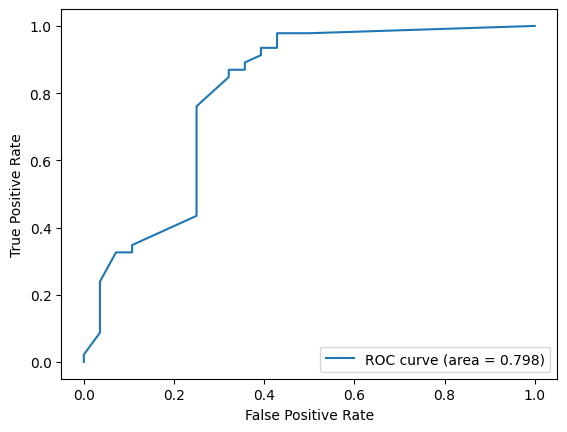

In [173]:
X_train = X.copy(deep=True)
X_train['Gender'] = X_train['Gender'].map(lambda x:0 if x=='Male' else 1)
X_train['Married'] = X_train['Married'].map(lambda x:0 if x=='No' else 1)
X_train['Education'] = X_train['Education'].map(lambda x:0 if x=='Not Graduate' else 1)
X_train['Self_Employed'] = X_train['Self_Employed'].map(lambda x:0 if x=='No' else 1)
X_train['Property_Area'] = X_train['Property_Area'].map({'Urban':0,'Semiurban':1,'Rural':2})
X_vali = Xv.copy(deep=True)
X_vali['Gender'] = X_vali['Gender'].map(lambda x:0 if x=='Male' else 1)
X_vali['Married'] = X_vali['Married'].map(lambda x:0 if x=='No' else 1)
X_vali['Education'] = X_vali['Education'].map(lambda x:0 if x=='Not Graduate' else 1)
X_vali['Self_Employed'] = X_vali['Self_Employed'].map(lambda x:0 if x=='No' else 1)
X_vali['Property_Area'] = X_vali['Property_Area'].map({'Urban':0,'Semiurban':1,'Rural':2})
y_train = y.copy(deep=True)
y_train = np.array(y_train.map(lambda x:0 if x=='N' else 1)).reshape(y_train.size)
y_vali = yv.copy(deep=True)
y_vali = np.array(y_vali.map(lambda x:0 if x=='N' else 1)).reshape(y_vali.size)

boosted = XGBClassifier(objective='reg:squarederror', learning_rate=0.1, tree_method='hist', max_depth=6, max_bin=3, n_estimators=2)
boosted.fit(X_train,y_train)
pred = boosted.predict_proba(X_vali)[:,1]
fpr,tpr,thresholds = roc_curve(y_vali,pred)
roc_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, label=f'ROC curve (area = {round(roc_auc,3)})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [172]:
### /// ### /// ###
###   Scratch   ###

# temp = data_valid[:72].copy(deep=True)
# temp.reset_index(inplace=True, drop=True)
# temp.drop('Loan_ID', axis=1, inplace=True)
# temp.iloc[[7, 10, 11, 15, 20, 28, 29, 31, 32, 39, 43, 44, 64, 71]]

### /// ### /// ### x-μ/σ